In [2]:
import sys
sys.path.append("/Users/yzhiyuan/workspace/DENV_10X/notebook/") #enter the lib.util file directory
import lib.util
from lib.util import *

In [264]:
def pre_processing_1(adata, cell_type):
    temp = adata[adata.obs.cell_type_new == cell_type].copy()
    sc.pp.filter_genes(temp, min_cells=3)
    
    virus_nor(temp)
    
    ind = temp.obs.DENV_reads_nor.sort_values(ascending = False).head(100).index

    temp.obs['bystanders'] = 'low'
    temp.obs.loc[ind, 'bystanders'] = 'high'
    temp.obs.loc[temp.obs.DENV_reads_nor==0, 'bystanders'] = 'zero'
    
    return(temp)

def pre_processing_2(adata):
    temp = adata.copy()
    sc.pp.filter_genes(temp, min_cells=3)
    
    virus_nor(temp)
    
    temp.obs['bystanders'] = 'high'
    temp.obs.loc[temp.obs.DENV_reads_nor==0, 'bystanders'] = 'zero'
    
    return(temp)

def violin_virus(adata, color, path, name, filetype):
    rcParams['figure.figsize']=(6,6)
    rcParams['font.size']=18
    rcParams['pdf.fonttype'] = 42
    rcParams['font.sans-serif'] = "Arial"
    
    fig, ax = plt.subplots()
    
    adata.obs['bystanders_2'] = 'bystanders'
    adata.obs.loc[adata.obs.bystanders != 'zero', 'bystanders_2'] = 'VHCs'
    
    sc.pl.violin(adata, ['DENV_reads_nor'], groupby = 'bystanders_2', palette = color, ax = ax)
    
    ax.set_ylabel('DENV reads (log2(cpm))')
    ax.set_xlabel('B cells')
    ind = ax.get_xticks()
    print(ind)
    ax.set_xticklabels(['VHCs', 'Bystanders'])
    
    ax.set_title('VHCs vs Bystanders')
    
    filename = name + '.' + filetype

    fig.savefig(os.path.join(path, filename),
               bbox_inches='tight')
    
def get_df(adata, group):
    dic = {}
    colnames = ['names', 'scores', 'logfoldchanges', 'pvals', 'pvals_adj']
    for x in colnames:
        dic[x] = adata.uns['wilcoxon'][x][group]
    df = pd.DataFrame(dic)
    df.set_index('names', inplace = True)
    return(df)
    
def utest(adata):
    temp = adata[adata.obs.bystanders != 'low'].copy()
    sc.tl.rank_genes_groups(temp, 'bystanders', method='wilcoxon', 
                            key_added = "wilcoxon", corr_method = 'bonferroni')
    
    df_utest = get_df(temp, 'high')
    df_utest_2 = df_utest.loc[(df_utest.pvals_adj<0.05)&(df_utest.logfoldchanges.abs()>1)]
    return(df_utest_2)

from random import sample

def sampling(adata):
    ind_bystander = list(adata[adata.obs.loc[:,'bystanders'] == 'zero',].obs.index)
    length_vhc = len(adata[adata.obs.loc[:,'bystanders'] == 'high',].obs.index)
    samplelist = sample(ind_bystander, length_vhc)
    
    return(samplelist)

def dge_KS(adata, samplelist, p):
    adata_1 = adata[np.in1d(adata.obs.index, samplelist),:]
    adata_2 = adata[adata.obs.loc[:,'bystanders'] == 'high',:]
    results = anndataks.compare(adata_1, adata_2, log1p=2)
    results_sort = results.sort_values(by = 'statistic', ascending=False)
    results_sort['-log10p'] = pd.Series(-np.log10(results_sort['pvalue']))
    results_sort_2 = results_sort[(results_sort['-log10p'] > p) & (results_sort['log2_fold_change'].abs() > 1)].copy()
    
    return(results_sort, results_sort_2)

def bootstrap(adata, n, p):
    dic_1 = {}
    dic_2 = {}
    for x in np.arange(n):
        sample_list = sampling(adata)
        result_temp_1,  result_temp_2 = dge_KS(adata, sample_list, p)
        dic_1[x] = result_temp_1
        dic_2[x] = result_temp_2
        
        gene = []
    for key in dic_2.keys():
        gene = gene + list(dic_2[key].index)
    a = pd.Series(gene).value_counts().to_frame()
    return(dic_1, dic_2, a)

def dge_KS_2(adata, samplelist, p):
    adata_1 = adata[np.in1d(adata.obs.index, samplelist),:]
    adata_2 = adata[adata.obs.loc[:,'bystanders'] == 'high',:]
    results = anndataks.compare(adata_1, adata_2, log1p=2)
    results_sort = results.sort_values(by = 'statistic', ascending=False)
    results_sort['-log10p'] = pd.Series(-np.log10(results_sort['pvalue']))
    results_sort_2 = results_sort[(results_sort['log2_fold_change'].abs() > 1)].copy()
    
    return(results_sort, results_sort_2)

def bootstrap_2(adata, n, p):
    dic_1 = {}
    dic_2 = {}
    for x in np.arange(n):
        sample_list = sampling(adata)
        result_temp_1,  result_temp_2 = dge_KS_2(adata, sample_list, p)
        dic_1[x] = result_temp_1
        dic_2[x] = result_temp_2
        
    gene = []
    for key in dic_2.keys():
        gene = gene + list(dic_2[key].index)
    a = pd.Series(gene).value_counts().to_frame()
    
    return(dic_1, dic_2, a)


def dicmerge(dic, gene_list):
    df_temp = pd.DataFrame(columns = np.arange(100), index = gene_list)
    for key in dic.keys():
        df_temp.loc[:,key] = dic[key].log2_fold_change
    df_temp['median'] = df_temp.median(axis = 1)
    return(df_temp)
        
def dicmerge_p(dic, gene_list):
    df_temp = pd.DataFrame(columns = np.arange(100), index = gene_list)
    for key in dic.keys():
        df_temp.loc[:,key] = dic[key].loc[:,'-log10p']
    df_temp['median'] = df_temp.median(axis = 1)
    return(df_temp)       

def pairwise_barplot(df, path, color, filetype, name, figure_size = (14, 12), xlim_down = -4.5, xlim_up = 4):
    rcParams['figure.figsize']=figure_size
    rcParams['font.size']=18
    rcParams['pdf.fonttype'] = 42
    rcParams['font.sans-serif'] = "Arial"
    
    df['VHC vs Bystander'] = 'no difference'
    df.loc[df['median'] < -1, 'VHC vs Bystander'] = 'downregulate'
    df.loc[df['median'] > 1, 'VHC vs Bystander'] = 'upregulate'
    
    data = df.iloc[:,:-1].copy()
    data['gene'] = data.index
    data['VHC vs Bystander'] = df.loc[:,'VHC vs Bystander'].copy()
    
    
    data_2 = pd.melt(data, id_vars = ['gene', 'VHC vs Bystander'])
       
    fig, ax = plt.subplots()
    ax = sb.boxplot(data = data_2, x = 'value', y = 'gene', orient = 'h', hue = 'VHC vs Bystander',
                   hue_order = ['upregulate', 'no difference', 'downregulate'], 
                    palette = color, dodge = False)
    
    ax.axvline(x = 0, ls = '--', lw = 2, c = 'black')
    ax.axvline(x = 1, ls = '--', lw = 2, c = 'black')
    ax.axvline(x = -1, ls = '--', lw = 2, c = 'black')
    
    ax.set_xlabel('diff_log2(cpm)')
    ax.set_title(name)
    
    
    ax.set_xlim(xlim_down,xlim_up)
    filename = name + '.' + filetype

    fig.savefig(os.path.join(path, filename),
               bbox_inches='tight')
    
def find_overlap(df_list, cutoff):
    overlap = []
    n = 0
    for df in df_list:
        if n == 0:
            overlap = list(df.loc[df[0] >=cutoff].index)
        else:
            overlap = [x for x in overlap if x in df.loc[df[0] >=cutoff].index]
        n = n + 1
        print(len(overlap))
    return(overlap)
    
def barplot_multiple(df_list, n_cutoff_list, path, color, filetype, name_list, figure_size = (14, 12)):
    rcParams['figure.figsize']=figure_size
    rcParams['font.size']=18
    rcParams['pdf.fonttype'] = 42
    rcParams['font.sans-serif'] = "Arial"
    
    fig_ind=np.arange(151, 157) #index of the figure, the add_subplot has to be 3 digit
    fig = plt.figure()
    fig.subplots_adjust(hspace=1.5, wspace=0.05)
    
    ind = 0
    for df in df_list:
        genes_survival = list(n_cutoff_list[ind].loc[n_cutoff_list[ind][0]>=70].index)
        df['VHC vs Bystander'] = 'no difference'
        
        ind_down = [x for x in df.loc[df['median'] < -1].index if x in genes_survival]
        ind_up = [x for x in df.loc[df['median'] > 1].index if x in genes_survival]
        
        df.loc[ind_down, 'VHC vs Bystander'] = 'downregulate'
        df.loc[ind_up, 'VHC vs Bystander'] = 'upregulate'
        
        data = df.iloc[:,:-1].copy()
        data['gene'] = data.index
        data['VHC vs Bystander'] = df.loc[:,'VHC vs Bystander'].copy()
        
        data_2 = pd.melt(data, id_vars = ['gene', 'VHC vs Bystander'])
        
        
        ax_temp = fig.add_subplot(fig_ind[ind])
        sb.boxplot(data = data_2, x = 'value', y = 'gene', orient = 'h', hue = 'VHC vs Bystander',
                   hue_order = ['upregulate', 'no difference', 'downregulate'],
                   palette = color, dodge = False, ax = ax_temp)
        
        ax_temp.set_xlabel('diff_log2(cpm)')
        ax_temp.set_ylabel('')
        ax_temp.set_title(name_list[ind])
        ax_temp.set_xlim(-4.5,4)
        
        ax_temp.axvline(x = 0, ls = '--', lw = 2, c = 'black')
        ax_temp.axvline(x = 1, ls = '--', lw = 2, c = 'black')
        ax_temp.axvline(x = -1, ls = '--', lw = 2, c = 'black')
        
        if ind != 0:
            ax_temp.get_legend().remove()
            ax_temp.tick_params(axis='y', which='both', labelleft=False)
        else:
            ax_temp.legend(bbox_to_anchor=[0, 1])
            

        ind = ind + 1
        
    
           
    filename = 'mutiple_cell_type_VHC.' + filetype
    fig.savefig(os.path.join(path, filename),
               bbox_inches='tight')
    
def bar_plot_other_celltype(dic_list, genelist):    
    new_list = []
    for dic in dic_list:      
        df_temp = dicmerge(dic, genelist)
#         df_temp = df_temp.sort_values(by = 'median', ascending = False)
        new_list.append(df_temp)
    
    return(new_list)    
    

In [199]:
#load data
path = '/Users/yzhiyuan/workspace/DENV_10X/PythonProject/PNAS_10X/mergedata_20211001.loom'
adata = getdata(path)

adata_kid = subsetdata(adata)
adata_kid = normalizedata(adata_kid)
adata_kid = removegenes(adata_kid)


#select high viral load 3 patients
ind = np.in1d(adata_kid.obs.ID, ['5_089_01', '6_025_01', '6_020_01'])
adata_kid_DWS = adata_kid[ind]

In [205]:
#subsetting to kids B cells and preprocessing
adata_kid_DWS = pre_processing_1(adata_kid_DWS, 'B_cells')

Trying to set attribute `.obs` of view, copying.


... storing 'Condition' as categorical
... storing 'DENV_minus' as categorical
... storing 'DENV_plus' as categorical
... storing 'Gender' as categorical
... storing 'ID' as categorical
... storing 'batch' as categorical
... storing 'cell_quality' as categorical
... storing 'cell_subtype' as categorical
... storing 'cell_subtype_2' as categorical
... storing 'cell_subtype_new' as categorical
... storing 'cell_type' as categorical
... storing 'cell_type_new' as categorical
... storing 'cell_type_new_2' as categorical
... storing 'doublets' as categorical
... storing 'platform' as categorical
... storing 'virus' as categorical
... storing 'bystanders' as categorical
... storing 'bystanders_2' as categorical
... storing 'feature_types_10X' as categorical
... storing 'feature_types_plate' as categorical


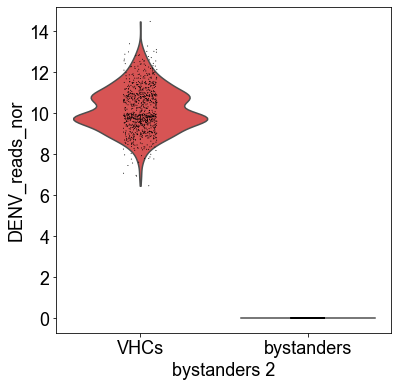

[0 1]


In [206]:
#Figure 2C (original Figure 2A)
temp = adata_kid_DWS.copy()
path = '/Users/yzhiyuan/workspace/DENV_10X/figures/Manuscript/raw_figure_V4'

violin_virus(temp, ['#ED3E3E', 'grey'], path, name = 'VHC_violin_B', filetype='pdf')

In [238]:
#for Figure 2D (original Figure 2B)

#try U test
df_utest_2 = utest(adata_kid_DWS)

#try bootstrap
dic_1, dic_2, df_boot = bootstrap_2(adata_kid_DWS, 100, 2)

#save the table
gene_list = df_boot.index
df = dicmerge(dic_1, gene_list)
df = df.sort_values(by = 'median', ascending = False)
df.to_csv('/Users/yzhiyuan/workspace/DENV_10X/tables/2022_1_13/df_B_top100.tsv', sep = '\t')



... storing 'Condition' as categorical
... storing 'DENV_minus' as categorical
... storing 'DENV_plus' as categorical
... storing 'Gender' as categorical
... storing 'ID' as categorical
... storing 'batch' as categorical
... storing 'cell_quality' as categorical
... storing 'cell_subtype' as categorical
... storing 'cell_subtype_2' as categorical
... storing 'cell_subtype_new' as categorical
... storing 'cell_type' as categorical
... storing 'cell_type_new' as categorical
... storing 'cell_type_new_2' as categorical
... storing 'doublets' as categorical
... storing 'platform' as categorical
... storing 'virus' as categorical
... storing 'bystanders' as categorical
... storing 'feature_types_10X' as categorical
... storing 'feature_types_plate' as categorical


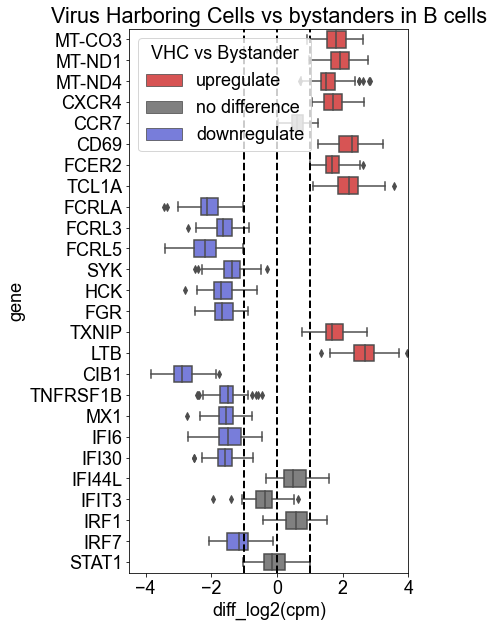

In [263]:
#plotting
genelist = ['MT-CO3', 'MT-ND1', 'MT-ND4', 'CXCR4', 'CCR7', 'CD69', 'FCER2', 'TCL1A', 'FCRLA','FCRL3', 'FCRL5', 'SYK', 'HCK', 'FGR',  
     'TXNIP', 'LTB', 'CIB1', 'TNFRSF1B', 'MX1', 'IFI6', 'IFI30',
'IFI44L', 'IFIT3', 'IRF1', 'IRF7', 'STAT1', 
'CXCR4', 'CD69']

df_temp = dicmerge(dic_1, genelist)
# df_temp = df_temp.sort_values(by = 'median', ascending = False)

path = '/Users/yzhiyuan/workspace/DENV_10X/figures/Manuscript/raw_figure_V4'
color = ['#ED3E3E', 'grey','#686EEA']
pairwise_barplot(df_temp, path, color,
                 'pdf', 'Virus Harboring Cells vs bystanders in B cells',figure_size = (5, 10))

In [212]:
#for Figure 2E (original Figure 2C), adult

#load data
adata_adult = subsetdata(adata, platform ='plate')
adata_adult = normalizedata(adata_adult)
adata_adult = removegenes(adata_adult)

In [218]:
#subsetting to adult B cells and preprocessing
adata_adult_B = pre_processing_1(adata_adult, 'B_cells')

Trying to set attribute `.obs` of view, copying.


In [ ]:
#try U test
# df_utest_2_a = utest(adata_adult_B)

#try bootstrap
dic_1_a, dic_2_a, df_boot_a = bootstrap(adata_adult_B, 100, 2)

#save the table
gene_list_a = df_boot_a.index
df_a = dicmerge(dic_1_a, gene_list_a)
df_a = df_a.sort_values(by = 'median', ascending = False)

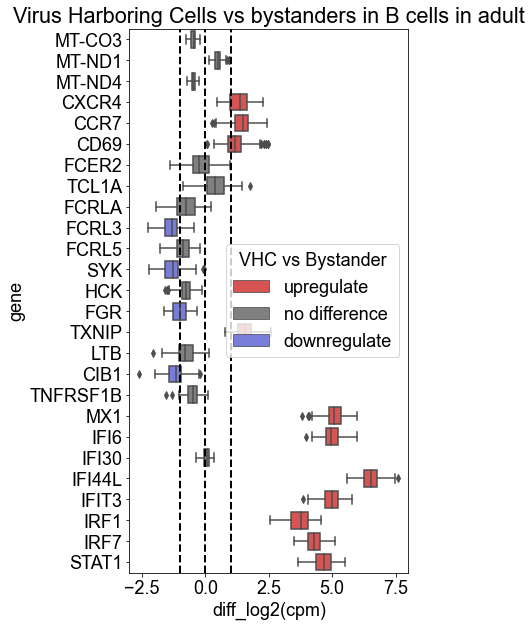

In [262]:
#plotting 
genelist = ['MT-CO3', 'MT-ND1', 'MT-ND4', 'CXCR4', 'CCR7', 'CD69', 'FCER2', 'TCL1A', 'FCRLA','FCRL3', 'FCRL5', 'SYK', 'HCK', 'FGR',  
     'TXNIP', 'LTB_1', 'CIB1', 'TNFRSF1B', 'MX1', 'IFI6', 'IFI30',
'IFI44L', 'IFIT3', 'IRF1', 'IRF7_1', 'STAT1', 
'CXCR4', 'CD69']

df_temp = dicmerge(dic_1_a, genelist)
# df_temp = df_temp.sort_values(by = 'median', ascending = False)

genes_2 = [x.split('_')[0] for x in df_temp.index]
df_temp.index = genes_2

path = '/Users/yzhiyuan/workspace/DENV_10X/figures/Manuscript/raw_figure_V4'
color = ['#ED3E3E', 'grey', '#686EEA']
pairwise_barplot(df_temp, path, color,
                 'pdf', 'Virus Harboring Cells vs bystanders in B cells in adult',
                figure_size = (5, 10), xlim_down = -3, xlim_up = 8)

In [19]:
#other cell types VHC dge, Figure 2F (original Figure 2D)

#B
adata_temp = adata_kid_DWS[adata_kid_DWS.obs.cell_type_new == 'B_cells'].copy()
adata_temp = pre_processing_2(adata_temp)
dic_b_1, dic_b_2, df_b = bootstrap_2(adata_temp, 100, 2)

#monocytes
adata_temp = adata_kid_DWS[adata_kid_DWS.obs.cell_type_new == 'Monocytes'].copy()
adata_temp = pre_processing_2(adata_temp)
dic_m_1, dic_m_2, df_m = bootstrap_2(adata_temp, 100, 2)


#Plasmablasts
adata_temp = adata_kid_DWS[adata_kid_DWS.obs.cell_type_new == 'Plasmablasts'].copy()
adata_temp = pre_processing_2(adata_temp)
dic_p_1, dic_p_2, df_p = bootstrap_2(adata_temp, 100, 2)

#NK
adata_temp = adata_kid_DWS[(adata_kid_DWS.obs.cell_subtype_new == 'XCL_low NK cells') | 
                     (adata_kid_DWS.obs.cell_subtype_new == 'XCL_high NK cells')].copy()
adata_temp = pre_processing_2(adata_temp)
dic_n_1, dic_n_2, df_n = bootstrap_2(adata_temp, 100, 2)

#T
adata_temp = adata_kid_DWS[(adata_kid_DWS.obs.cell_subtype_new == 'CD4+ T cells') | 
                     (adata_kid_DWS.obs.cell_subtype_new == 'CD8+ effector T cells') |
                     (adata_kid_DWS.obs.cell_subtype_new == 'CD8+ naive/memory T cells')].copy()
adata_temp = pre_processing_2(adata_temp)
dic_t_1, dic_t_2, df_t = bootstrap_2(adata_temp, 100, 2)



Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


In [61]:
df_m.loc[df_m[0] >=70]

,0
MS4A1,100
CD79A,100
MT-ATP6,99
IGHM,96
LSM7,94
MT-CO3,90
TCEA1,90
MT-CYB,90
HNRNPM,88
HLA-DQB1,88


In [66]:
df_n.loc[df_n[0] >=70]

,0
MT-ND4,100
MT-ND5,99
MT-ND2,97
MT-ND3,97
WIPF1,96
UBE2L3,91
MT-ND6,90
FAM177A1,89
MT-CO3,86
MT-ND4L,84


In [265]:
df_b.loc[df_b[0] >=70]

,0
STK17A,100
CALHM6,100
NFKBIA,100
MT-CYB,100
IFI30,100
...,...
SYK,83
IFI6,81
MS4A1,78
RPL38,74


In [96]:
df_b.loc[df_b[0] >=70].index

Index(['STK17A', 'CALHM6', 'NFKBIA', 'MT-CYB', 'IFI30', 'RPS9', 'FCRLA',
       'GAPDH', 'TXNIP', 'CRIP1', 'TPI1', 'C1orf162', 'LTB', 'PSAP', 'EMP3',
       'SELL', 'FGR', 'CXCR4', 'FCER2', 'SCIMP', 'TCL1A', 'MT2A', 'MT-ND4',
       'SEC61B', 'PLEK', 'MT-ND4L', 'FCRL5', 'CD69', 'S100A11', 'VPREB3',
       'FCRL3', 'FLNA', 'CIB1', 'ITGB2', 'IGHM', 'HCK', 'TNFRSF1B', 'DAPP1',
       'POU2F2', 'LBH', 'RCSD1', 'NEAT1', 'RPS4Y1', 'MT-CO3', 'MYL6', 'EEF1B2',
       'MT-ND1', 'RHOH', 'IGHG3', 'MX1', 'IGHG1', 'RPS5', 'TMEM123', 'COTL1',
       'MT-ATP6', 'CCR7', 'PPP1R14A', 'LINC00926', 'SYK', 'IFI6', 'MS4A1',
       'RPL38', 'GRN'],
      dtype='object')

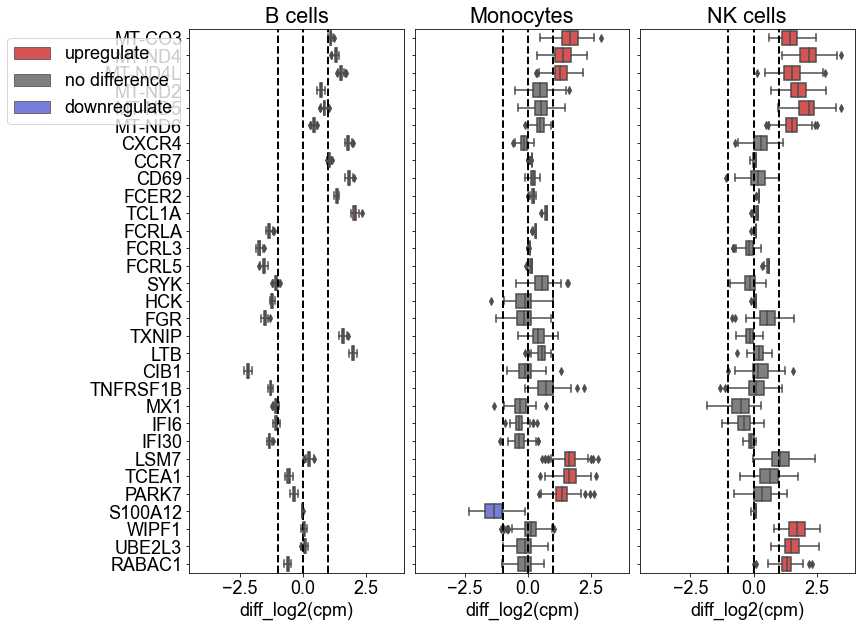

In [254]:
common = ['MT-CO3', 'MT-ND4', 'MT-ND4L','MT-ND2', 'MT-ND5', 'MT-ND6']
b = ['CXCR4', 'CCR7', 'CD69', 'FCER2', 'TCL1A', 'FCRLA','FCRL3', 'FCRL5', 'SYK', 'HCK', 'FGR',  
     'TXNIP', 'LTB', 'CIB1', 'TNFRSF1B', 'MX1', 'IFI6', 'IFI30']
m = ['LSM7', 'TCEA1', 'PARK7', 'S100A12']
n = ['WIPF1', 'UBE2L3', 'RABAC1']


genelist = common + b + m + n
dic_list = [dic_b_1, dic_m_1, dic_n_1]
n_cutoff_list = [df_b, df_m, df_n]

df_list = bar_plot_other_celltype(dic_list, genelist)
name_list = ['B cells', 'Monocytes', 'NK cells']

path = '/Users/yzhiyuan/workspace/DENV_10X/figures/Manuscript/raw_figure_V4'
color = ['#ED3E3E', 'grey', '#686EEA']

barplot_multiple(df_list, n_cutoff_list, path, color, 'pdf', name_list, figure_size = (20, 10))
